https://huggingface.co/SamLowe/roberta-base-go_emotions

Model trained from roberta-base on the go_emotions dataset for multi-label classification.
go_emotions is based on Reddit data and has 28 labels. It is a multi-label dataset where one or multiple labels may apply for any given input text, hence this model is a multi-label classification model with 28 'probability' float outputs for any given input text. Typically a threshold of 0.5 is applied to the probabilities for the prediction for each label.


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.nn.functional import softmax

In [3]:
model_checkpoint = 'SamLowe/roberta-base-go_emotions'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [4]:
labels = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity',
          'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
          'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
          'remorse', 'sadness', 'surprise', 'neutral']


core_emotions = ['joy', 'sadness', 'anger', 'fear', 'surprise']


In [5]:
def select_labels(emotion):
    label_mapping = {
        'admiration': 'joy', 'amusement': 'joy', 'approval': 'joy', 'caring': 'joy', 'gratitude': 'joy',
        'love': 'joy', 'optimism': 'joy', 'excitement': 'joy', 'relief': 'joy',
        'anger': 'anger', 'annoyance': 'anger', 'disapproval': 'anger', 'disgust': 'anger',
        'fear': 'fear', 'nervousness': 'fear',
        'sadness': 'sadness', 'disappointment': 'sadness', 'grief': 'sadness', 'remorse': 'sadness',
        'surprise': 'surprise', 'realization': 'surprise', 'confusion': 'surprise'
    }
    return label_mapping.get(emotion, 'neutral')



In [6]:
def predict_emotion(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    predicted_emotion = torch.argmax(probabilities, dim=1).item()
    emotion_label = labels[predicted_emotion]
    return select_labels(emotion_label)


In [7]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/wildfire_ca_nov18.csv')

df.head()

Mounted at /content/drive


Unnamed: 0       tweetID        userID         username  \
0           0  1.067632e+18  1.994659e+07      GabrielaDow   
1           1  1.067633e+18  1.994659e+07      GabrielaDow   
2           5  1.067649e+18  4.007743e+07        fnifatboy   
3           9  1.067635e+18  2.551068e+09  _kassbekillinem   
4          17  1.067636e+18  1.418597e+08   QueenNiNiBee25   

                  date                                            message  \
0  2018-11-27 23:12:16  @mclanea Spent the day alternating beyween lap...   
1  2018-11-27 23:16:09  @mclanea Spent the day alternating between lap...   
2  2018-11-28 00:17:30  @Alyssa_Milano Donate to kill unborn children ...   
3  2018-11-27 23:21:19  The camp fire song song from spongebob is lite...   
4  2018-11-27 23:27:50  Happy Birthday to my grandma ; rest in paradis...   

  geoType   longitude   latitude          place  ...  index_right  STATEFP  \
0   Place -117.104989  32.810012  San Diego; CA  ...            1        6   
1   Place -117.104989  32.810012  San Diego; CA  ...            1        6   
2   Place -117.462698  34.108160    Fontana; CA  ...            1        6   
3   Place -121.281374  38.875304    Lincoln; CA  ...            1        6   
4   Place -119.782465  36.786042     Fresno; CA  ...            1        6   

   STATENS     AFFGEOID GEOID STUSPS        NAME LSAD         ALAND  \
0  1779778  0400000US06     6     CA  California    0  403673617862   
1  1779778  0400000US06     6     CA  California    0  403673617862   
2  1779778  0400000US06     6     CA  California    0  403673617862   
3  1779778  0400000US06     6     CA  California    0  403673617862   
4  1779778  0400000US06     6     CA  California    0  403673617862   

        AWATER  
0  20291712025  
1  20291712025  
2  20291712025  
3  20291712025  
4  20291712025  

[5 rows x 47 columns]

In [8]:
df.shape

(13427, 47)

In [8]:
dataset_size = len(df)
subset_size = 1500

num_subsets = (dataset_size + subset_size - 1) // subset_size

subsets = [df[i*subset_size:(i+1)*subset_size] for i in range(num_subsets)]

In [9]:
import torch

def sentiment_score(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    return predicted_class

In [10]:
tweets = [
    "I hope that candidate that I support wins the election!",
    "Who did you vote for?",
    "I cannot believe he's losing!",
    "If he doesn't like cakes, I'm not voting for him anymore."
]

for t in tweets:
    print(predict_emotion(t))


joy
neutral
surprise
anger


In [11]:


def batch_predict_emotion(texts, batch_size=32):
    encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    num_texts = len(texts)
    predicted_emotions = []

    for i in range(0, num_texts, batch_size):
        batch_inputs = {key: val[i:i+batch_size] for key, val in encoded_inputs.items()}

        with torch.no_grad():
            outputs = model(**batch_inputs)
            logits = outputs.logits
            probabilities = softmax(logits, dim=1)
            predicted_classes = torch.argmax(probabilities, dim=1)

        for idx in predicted_classes.tolist():
            predicted_emotion = labels[idx]
            predicted_emotions.append(select_labels(predicted_emotion))

        if (i + batch_size) % 320 == 0:
            print(f"Processed {i + batch_size} texts")

    return predicted_emotions

In [12]:
tweets_first = subsets[0]['message'].tolist()
tweets_second = subsets[1]['message'].tolist()
tweets_third = subsets[2]['message'].tolist()
tweets_fourth = subsets[3]['message'].tolist()
tweets_fifth = subsets[4]['message'].tolist()
tweets_sixth = subsets[5]['message'].tolist()
tweets_seventh = subsets[6]['message'].tolist()
tweets_eighth = subsets[7]['message'].tolist()
tweets_ninth = subsets[8]['message'].tolist()

In [13]:
tweets = df['message'].tolist()

In [14]:
#for i in range(9):
  #subsets[i]['sentiments'] = batch_predict_emotion(subsets[i]['message'].tolist())
  #name = f'/content/drive/MyDrive/{i+1}_subset_goemotions.csv'
  #subsets[i].to_csv(name, index=False)
  #print(f"Subset {i+1} saved to {name}")

In [ ]:
!pip install gpustat


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 7.3 MB/s eta 0:00:00
  Created wheel for gpustat: filename=gpustat-1.1.1-py3-none-any.whl size=26535 sha256=2356434f18eb9a420640537540251fb75f06f1b1738d319265c30145e6415d07
  Stored in directory: /root/.cache/pip/wheels/ec/d7/80/a71ba3540900e1f276bcae685efd8e590c810d2108b95f1e47
Successfully built gpustat


In [22]:
subsets[0]['emotions'] = batch_predict_emotion(tweets_first)

subsets[0].to_csv('/content/drive/MyDrive/first_subset_goemotions.csv', index=False)

Processed 320 texts
Processed 640 texts
Processed 960 texts
Processed 1280 texts


<ipython-input-22-7158eb1facdc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsets[0]['emotions'] = batch_predict_emotion(tweets_first)


In [23]:
subsets[0].head()

Unnamed: 0       tweetID        userID         username  \
0           0  1.067632e+18  1.994659e+07      GabrielaDow   
1           1  1.067633e+18  1.994659e+07      GabrielaDow   
2           5  1.067649e+18  4.007743e+07        fnifatboy   
3           9  1.067635e+18  2.551068e+09  _kassbekillinem   
4          17  1.067636e+18  1.418597e+08   QueenNiNiBee25   

                  date                                            message  \
0  2018-11-27 23:12:16  @mclanea Spent the day alternating beyween lap...   
1  2018-11-27 23:16:09  @mclanea Spent the day alternating between lap...   
2  2018-11-28 00:17:30  @Alyssa_Milano Donate to kill unborn children ...   
3  2018-11-27 23:21:19  The camp fire song song from spongebob is lite...   
4  2018-11-27 23:27:50  Happy Birthday to my grandma ; rest in paradis...   

  geoType   longitude   latitude          place  ...  STATEFP  STATENS  \
0   Place -117.104989  32.810012  San Diego; CA  ...        6  1779778   
1   Place -117.104989  32.810012  San Diego; CA  ...        6  1779778   
2   Place -117.462698  34.108160    Fontana; CA  ...        6  1779778   
3   Place -121.281374  38.875304    Lincoln; CA  ...        6  1779778   
4   Place -119.782465  36.786042     Fresno; CA  ...        6  1779778   

      AFFGEOID  GEOID STUSPS        NAME LSAD         ALAND       AWATER  \
0  0400000US06      6     CA  California    0  403673617862  20291712025   
1  0400000US06      6     CA  California    0  403673617862  20291712025   
2  0400000US06      6     CA  California    0  403673617862  20291712025   
3  0400000US06      6     CA  California    0  403673617862  20291712025   
4  0400000US06      6     CA  California    0  403673617862  20291712025   

  emotions  
0  neutral  
1  neutral  
2  neutral  
3      joy  
4      joy  

[5 rows x 48 columns]

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [24]:
subsets[1]['emotions'] = batch_predict_emotion(tweets_second)

subsets[1].to_csv('/content/drive/MyDrive/second_subset_goemotions.csv', index=False)

Processed 320 texts
Processed 640 texts
Processed 960 texts
Processed 1280 texts


<ipython-input-24-5e9b7785530f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsets[1]['emotions'] = batch_predict_emotion(tweets_second)


In [25]:
subsets[2]['emotions'] = batch_predict_emotion(tweets_third)

subsets[2].to_csv('/content/drive/MyDrive/third_subset_goemotions.csv', index=False)



Processed 320 texts
Processed 640 texts
Processed 960 texts
Processed 1280 texts


<ipython-input-25-a3856fb78b5d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsets[2]['emotions'] = batch_predict_emotion(tweets_third)


In [26]:
subsets[3]['emotions'] = batch_predict_emotion(tweets_fourth)

subsets[3].to_csv('/content/drive/MyDrive/fourth_subset_goemtions.csv', index=False)

Processed 320 texts
Processed 640 texts
Processed 960 texts
Processed 1280 texts


<ipython-input-26-db93ef5a97a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsets[3]['emotions'] = batch_predict_emotion(tweets_fourth)


In [27]:
subsets[4]['emotions'] = batch_predict_emotion(tweets_fifth)

subsets[4].to_csv('/content/drive/MyDrive/fifth_subset_goemotions.csv', index=False)

Processed 320 texts
Processed 640 texts
Processed 960 texts
Processed 1280 texts


<ipython-input-27-5f1e030dfb5b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsets[4]['emotions'] = batch_predict_emotion(tweets_fifth)


In [15]:
subsets[5]['emotions'] = batch_predict_emotion(tweets_sixth)

subsets[5].to_csv('/content/drive/MyDrive/sixth_subset_goemotions.csv', index=False)

Processed 320 texts
Processed 640 texts
Processed 960 texts
Processed 1280 texts


<ipython-input-15-25cff9afe6f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsets[5]['emotions'] = batch_predict_emotion(tweets_sixth)


In [16]:
subsets[6]['emotions'] = batch_predict_emotion(tweets_seventh)

subsets[6].to_csv('/content/drive/MyDrive/seventh_subset_goemotions.csv', index=False)

Processed 320 texts
Processed 640 texts
Processed 960 texts
Processed 1280 texts


<ipython-input-16-26624b04db13>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsets[6]['emotions'] = batch_predict_emotion(tweets_seventh)


In [17]:
subsets[7]['emotions'] = batch_predict_emotion(tweets_eighth)

subsets[7].to_csv('/content/drive/MyDrive/eighth_subset_goemotions.csv', index=False)

Processed 320 texts
Processed 640 texts
Processed 960 texts
Processed 1280 texts


<ipython-input-17-8b36caccf81b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsets[7]['emotions'] = batch_predict_emotion(tweets_eighth)


In [18]:
subsets[8]['emotions'] = batch_predict_emotion(tweets_ninth)

subsets[8].to_csv('/content/drive/MyDrive/ninth_subset_goemotions.csv', index=False)

Processed 320 texts
Processed 640 texts
Processed 960 texts
Processed 1280 texts


<ipython-input-18-b44bf977b650>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsets[8]['emotions'] = batch_predict_emotion(tweets_ninth)


In [17]:
df_labeled = pd.concat([subsets[0], subsets[1], subsets[2], subsets[3], subsets[4], subsets[5], subsets[6], subsets[7], subsets[8]], axis=0, ignore_index=True)


In [18]:
df_labeled.to_csv('/content/drive/MyDrive/labeled_text_goemotions.csv', index=False)

In [20]:
df_labeled.head()

Unnamed: 0       tweetID        userID         username  \
0           0  1.067632e+18  1.994659e+07      GabrielaDow   
1           1  1.067633e+18  1.994659e+07      GabrielaDow   
2           5  1.067649e+18  4.007743e+07        fnifatboy   
3           9  1.067635e+18  2.551068e+09  _kassbekillinem   
4          17  1.067636e+18  1.418597e+08   QueenNiNiBee25   

                  date                                            message  \
0  2018-11-27 23:12:16  @mclanea Spent the day alternating beyween lap...   
1  2018-11-27 23:16:09  @mclanea Spent the day alternating between lap...   
2  2018-11-28 00:17:30  @Alyssa_Milano Donate to kill unborn children ...   
3  2018-11-27 23:21:19  The camp fire song song from spongebob is lite...   
4  2018-11-27 23:27:50  Happy Birthday to my grandma ; rest in paradis...   

  geoType   longitude   latitude          place  ...  STATEFP  STATENS  \
0   Place -117.104989  32.810012  San Diego; CA  ...        6  1779778   
1   Place -117.104989  32.810012  San Diego; CA  ...        6  1779778   
2   Place -117.462698  34.108160    Fontana; CA  ...        6  1779778   
3   Place -121.281374  38.875304    Lincoln; CA  ...        6  1779778   
4   Place -119.782465  36.786042     Fresno; CA  ...        6  1779778   

      AFFGEOID  GEOID STUSPS        NAME LSAD         ALAND       AWATER  \
0  0400000US06      6     CA  California    0  403673617862  20291712025   
1  0400000US06      6     CA  California    0  403673617862  20291712025   
2  0400000US06      6     CA  California    0  403673617862  20291712025   
3  0400000US06      6     CA  California    0  403673617862  20291712025   
4  0400000US06      6     CA  California    0  403673617862  20291712025   

  sentiments  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  

[5 rows x 48 columns]

In [ ]:
df_new = pd.read_csv('/content/drive/MyDrive/labeled_text_w_county.csv')

In [ ]:
#df_labeled['city'] = df_labeled['place'].apply(lambda x: x.split(';')[0].strip())

average_sentiment_by_city = df_new.groupby('county_name')['sentiments'].mean().reset_index().round(2)

print(average_sentiment_by_city)


        county_name  sentiments
0           Alameda        0.76
1            Amador        1.17
2             Butte        0.89
3         Calaveras        0.83
4            Colusa        0.75
5      Contra Costa        0.65
6         Del Norte        0.67
7         El Dorado        0.75
8            Fresno        0.72
9             Glenn        0.79
10         Humboldt        1.00
11         Imperial        0.40
12             Inyo        2.00
13             Kern        0.93
14            Kings        1.00
15             Lake        0.78
16           Lassen        1.00
17      Los Angeles        0.89
18           Madera        0.88
19            Marin        0.87
20         Mariposa        2.00
21        Mendocino        0.56
22           Merced        0.97
23             Mono        0.40
24         Monterey        0.64
25             Napa        0.75
26           Nevada        1.06
27           Orange        0.82
28           Placer        0.87
29           Plumas        1.00
30      

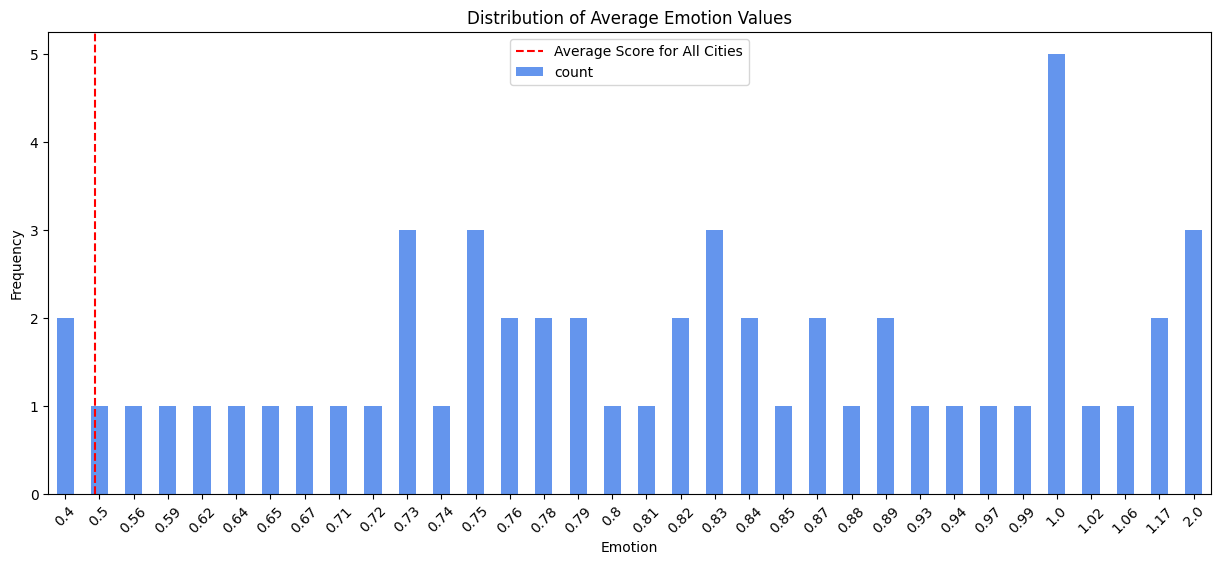

In [ ]:
import matplotlib.pyplot as plt

average_score_all_cities = average_sentiment_by_city['sentiments'].mean()

plt.figure(figsize=(15, 6))
average_sentiment_by_city['sentiments'].value_counts().sort_index().plot(kind='bar', color='cornflowerblue')
plt.title('Distribution of Average Emotion Values')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.axvline(x=average_score_all_cities, color='red', linestyle='--', label='Average Score for All Cities')

plt.legend()
plt.show()

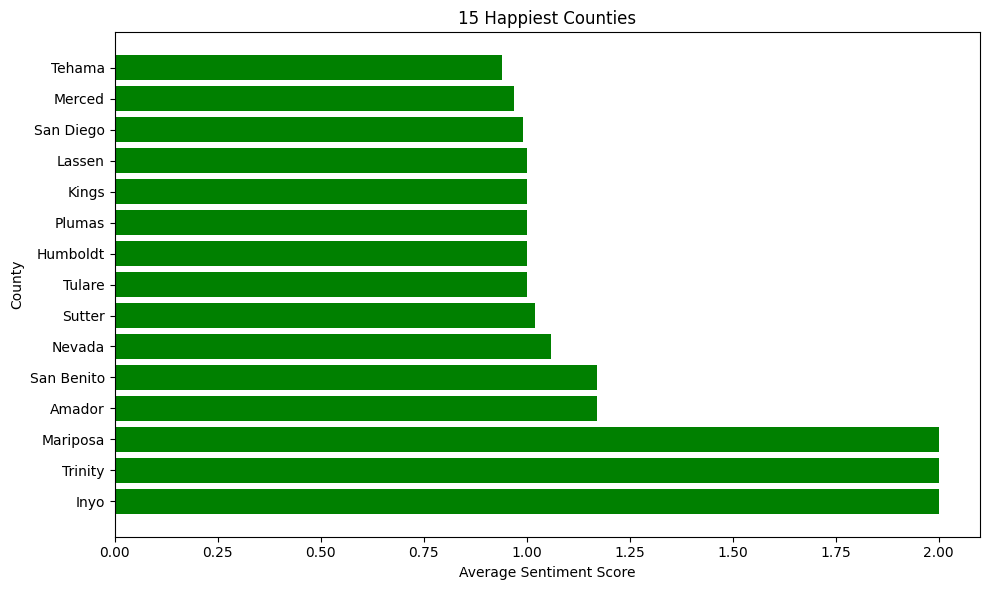

In [ ]:
sorted_cities = average_sentiment_by_city.sort_values(by='sentiments', ascending=False)

top_15_cities = sorted_cities.head(15)
bottom_15_cities = sorted_cities.tail(15)

plt.figure(figsize=(10, 6))
plt.barh(top_15_cities['county_name'], top_15_cities['sentiments'], color='green')
plt.title('15 Happiest Counties')
plt.ylabel('County')
plt.xlabel('Average Sentiment Score')
plt.tight_layout()
plt.show()

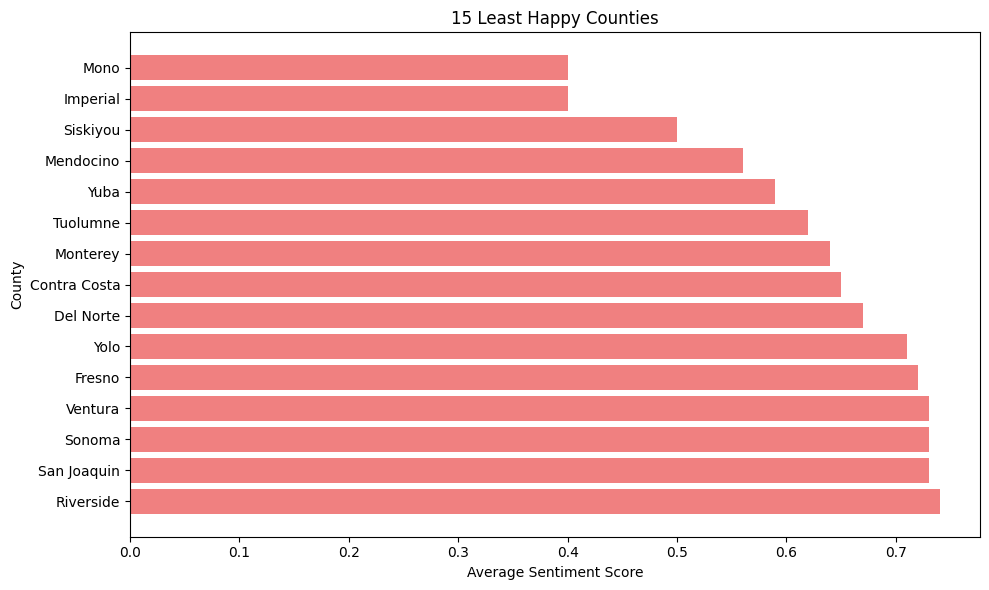

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(bottom_15_cities['county_name'], bottom_15_cities['sentiments'], color='lightcoral')
plt.title('15 Least Happy Counties')
plt.ylabel('County')
plt.xlabel('Average Sentiment Score')
plt.tight_layout()
plt.show()

In [ ]:
Social = pd.read_csv('/content/drive/MyDrive/ACSDP1Y2017.DP02-2024-05-24T034951.csv')
Economics = pd.read_csv('/content/drive/MyDrive/ACSDP1Y2017.DP03-2024-05-24T035107.csv')
Housing = pd.read_csv('/content/drive/MyDrive/ACSDP1Y2017.DP04-2024-05-24T035125.csv')
Demographic = pd.read_csv('/content/drive/MyDrive/ACSDP1Y2017.DP05-2024-05-24T035154.csv')

In [ ]:
Social.head()

Label (Grouping) California!!Estimate  \
0                                 HOUSEHOLDS BY TYPE                  NaN   
1                                   Total households           13,005,097   
2                       Family households (families)            8,910,617   
3              With own children of the household...            3,879,831   
4                              Married-couple family            6,446,965   

  California!!Margin of Error California!!Percent  \
0                         NaN                 NaN   
1                     ±17,539          13,005,097   
2                     ±24,114               68.5%   
3                     ±21,328               29.8%   
4                     ±27,509               49.6%   

  California!!Percent Margin of Error Alameda County, California!!Estimate  \
0                                 NaN                                  NaN   
1                                 (X)                              573,589   
2                                ±0.2                              379,364   
3                                ±0.2                              169,708   
4                                ±0.2                              283,896   

  Alameda County, California!!Margin of Error  \
0                                         NaN   
1                                      ±3,461   
2                                      ±4,995   
3                                      ±4,851   
4                                      ±5,916   

  Alameda County, California!!Percent  \
0                                 NaN   
1                             573,589   
2                               66.1%   
3                               29.6%   
4                               49.5%   

  Alameda County, California!!Percent Margin of Error  \
0                                                NaN    
1                                                (X)    
2                                               ±0.8    
3                                               ±0.9    
4                                               ±1.0    

  Butte County, California!!Estimate  ... Ventura County, California!!Percent  \
0                                NaN  ...                                 NaN   
1                             88,797  ...                             272,085   
2                             52,379  ...                               71.8%   
3                             19,690  ...                               29.8%   
4                             36,738  ...                               54.5%   

  Ventura County, California!!Percent Margin of Error  \
0                                                NaN    
1                                                (X)    
2                                               ±1.5    
3                                               ±1.2    
4                                               ±1.5    

  Yolo County, California!!Estimate Yolo County, California!!Margin of Error  \
0                               NaN                                      NaN   
1                            73,495                                   ±1,504   
2                            45,502                                   ±2,174   
3                            22,165                                   ±1,895   
4                            35,036                                   ±2,392   

  Yolo County, California!!Percent  \
0                              NaN   
1                           73,495   
2                            61.9%   
3                            30.2%   
4                            47.7%   

  Yolo County, California!!Percent Margin of Error  \
0                                              NaN   
1                                              (X)   
2                                             ±2.7   
3                                             ±2.5   
4                                             ±3.2   

  Yuba County, California!!Estimate

In [ ]:
from tabulate import tabulate

print(tabulate(Social, headers='keys', tablefmt='psql'))

+-----+------------------------------------------------------------------------------+------------------------+-------------------------------+-----------------------+---------------------------------------+----------------------------------------+-----------------------------------------------+---------------------------------------+-------------------------------------------------------+--------------------------------------+---------------------------------------------+-------------------------------------+-----------------------------------------------------+---------------------------------------------+----------------------------------------------------+--------------------------------------------+------------------------------------------------------------+------------------------------------------+-------------------------------------------------+-----------------------------------------+---------------------------------------------------------+---------------------------------

In [ ]:
Economics.head()

Label (Grouping) California!!Estimate  \
0                 EMPLOYMENT STATUS                  NaN   
1      Population 16 years and over           31,510,759   
2                    In labor force           20,064,003   
3              Civilian labor force           19,936,052   
4                          Employed           18,757,501   

  California!!Margin of Error California!!Percent  \
0                         NaN                 NaN   
1                     ±11,155          31,510,759   
2                     ±43,637               63.7%   
3                     ±43,965               63.3%   
4                     ±47,615               59.5%   

  California!!Percent Margin of Error Alameda County, California!!Estimate  \
0                                 NaN                                  NaN   
1                                 (X)                            1,355,096   
2                                ±0.1                              914,925   
3                                ±0.1                              913,865   
4                                ±0.1                              870,985   

  Alameda County, California!!Margin of Error  \
0                                         NaN   
1                                      ±1,595   
2                                      ±7,172   
3                                      ±7,275   
4                                      ±8,163   

  Alameda County, California!!Percent  \
0                                 NaN   
1                           1,355,096   
2                               67.5%   
3                               67.4%   
4                               64.3%   

  Alameda County, California!!Percent Margin of Error  \
0                                                NaN    
1                                                (X)    
2                                               ±0.5    
3                                               ±0.6    
4                                               ±0.6    

  Butte County, California!!Estimate  ... Ventura County, California!!Percent  \
0                                NaN  ...                                 NaN   
1                            188,525  ...                             678,464   
2                            106,233  ...                               65.7%   
3                            106,128  ...                               65.2%   
4                             98,494  ...                               61.8%   

  Ventura County, California!!Percent Margin of Error  \
0                                                NaN    
1                                                (X)    
2                                               ±0.8    
3                                               ±0.8    
4                                               ±0.9    

  Yolo County, California!!Estimate Yolo County, California!!Margin of Error  \
0                               NaN                                      NaN   
1                           178,343                                     ±789   
2                           109,053                                   ±2,624   
3                           109,015                                   ±2,639   
4                           101,482                                   ±3,265   

  Yolo County, California!!Percent  \
0                              NaN   
1                          178,343   
2                            61.1%   
3                            61.1%   
4                            56.9%   

  Yolo County, California!!Percent Margin of Error  \
0                                              NaN   
1                                              (X)   
2                                             ±1.5   
3                                             ±1.5   
4                                             ±1.9   

  Yuba County, California!!Estimate Yuba County, California!!Margin of Error  \
0                               NaN     

In [ ]:
print(tabulate(Economics, headers='keys', tablefmt='psql'))

+-----+-------------------------------------------------------------------------------------------------+------------------------+-------------------------------+-----------------------+---------------------------------------+----------------------------------------+-----------------------------------------------+---------------------------------------+-------------------------------------------------------+--------------------------------------+---------------------------------------------+-------------------------------------+-----------------------------------------------------+---------------------------------------------+----------------------------------------------------+--------------------------------------------+------------------------------------------------------------+------------------------------------------+-------------------------------------------------+-----------------------------------------+---------------------------------------------------------+--------------

In [ ]:
Housing.head()

Label (Grouping) California!!Estimate  \
0               HOUSING OCCUPANCY                  NaN   
1             Total housing units           14,177,270   
2          Occupied housing units           13,005,097   
3            Vacant housing units            1,172,173   
4          Homeowner vacancy rate                  1.0   

  California!!Margin of Error California!!Percent  \
0                         NaN                 NaN   
1                        ±934          14,177,270   
2                     ±17,539               91.7%   
3                     ±17,614                8.3%   
4                        ±0.1                 (X)   

  California!!Percent Margin of Error Alameda County, California!!Estimate  \
0                                 NaN                                  NaN   
1                                 (X)                              606,053   
2                                ±0.1                              573,589   
3                                ±0.1                               32,464   
4                                 (X)                                  0.4   

  Alameda County, California!!Margin of Error  \
0                                         NaN   
1                                        ±965   
2                                      ±3,461   
3                                      ±3,310   
4                                        ±0.2   

  Alameda County, California!!Percent  \
0                                 NaN   
1                             606,053   
2                               94.6%   
3                                5.4%   
4                                 (X)   

  Alameda County, California!!Percent Margin of Error  \
0                                                NaN    
1                                                (X)    
2                                               ±0.5    
3                                               ±0.5    
4                                                (X)    

  Butte County, California!!Estimate  ... Ventura County, California!!Percent  \
0                                NaN  ...                                 NaN   
1                             99,405  ...                             288,778   
2                             88,797  ...                               94.2%   
3                             10,608  ...                                5.8%   
4                                0.7  ...                                 (X)   

  Ventura County, California!!Percent Margin of Error  \
0                                                NaN    
1                                                (X)    
2                                               ±0.8    
3                                               ±0.8    
4                                                (X)    

  Yolo County, California!!Estimate Yolo County, California!!Margin of Error  \
0                               NaN                                      NaN   
1                            77,948                                     ±465   
2                            73,495                                   ±1,504   
3                             4,453                                   ±1,364   
4                               0.8                                     ±0.9   

  Yolo County, California!!Percent  \
0                              NaN   
1                           77,948   
2                            94.3%   
3                             5.7%   
4                              (X)   

  Yolo County, California!!Percent Margin of Error  \
0                                              NaN   
1                                              (X)   
2                                             ±1.8   
3                                             ±1.8   
4                                              (X)   

  Yuba County, California!!Estimate Yuba County, California!!Margin of Error  \
0                               NaN               

In [ ]:
print(tabulate(Housing, headers='keys', tablefmt='psql'))

+-----+------------------------------------------------------------------------------------+------------------------+-------------------------------+-----------------------+---------------------------------------+----------------------------------------+-----------------------------------------------+---------------------------------------+-------------------------------------------------------+--------------------------------------+---------------------------------------------+-------------------------------------+-----------------------------------------------------+---------------------------------------------+----------------------------------------------------+--------------------------------------------+------------------------------------------------------------+------------------------------------------+-------------------------------------------------+-----------------------------------------+---------------------------------------------------------+---------------------------

In [ ]:
Demographic.head()

Label (Grouping) California!!Estimate  \
0                                SEX AND AGE                  NaN   
1                           Total population           39,536,653   
2                                       Male           19,650,051   
3                                     Female           19,886,602   
4          Sex ratio (males per 100 females)                 98.8   

  California!!Margin of Error California!!Percent  \
0                         NaN                 NaN   
1                       *****          39,536,653   
2                      ±4,631               49.7%   
3                      ±4,631               50.3%   
4                        ±0.1                 (X)   

  California!!Percent Margin of Error Alameda County, California!!Estimate  \
0                                 NaN                                  NaN   
1                                 (X)                            1,663,190   
2                                ±0.1                              818,161   
3                                ±0.1                              845,029   
4                                 (X)                                 96.8   

  Alameda County, California!!Margin of Error  \
0                                         NaN   
1                                       *****   
2                                        ±482   
3                                        ±482   
4                                        ±0.1   

  Alameda County, California!!Percent  \
0                                 NaN   
1                           1,663,190   
2                               49.2%   
3                               50.8%   
4                                 (X)   

  Alameda County, California!!Percent Margin of Error  \
0                                                NaN    
1                                                (X)    
2                                               ±0.1    
3                                               ±0.1    
4                                                (X)    

  Butte County, California!!Estimate  ... Ventura County, California!!Percent  \
0                                NaN  ...                                 NaN   
1                            229,294  ...                             854,223   
2                            113,399  ...                               49.5%   
3                            115,895  ...                               50.5%   
4                               97.8  ...                                 (X)   

  Ventura County, California!!Percent Margin of Error  \
0                                                NaN    
1                                                (X)    
2                                               ±0.1    
3                                               ±0.1    
4                                                (X)    

  Yolo County, California!!Estimate Yolo County, California!!Margin of Error  \
0                               NaN                                      NaN   
1                           219,116                                    *****   
2                           106,261                                     ±640   
3                           112,855                                     ±640   
4                              94.2                                     ±1.1   

  Yolo County, California!!Percent  \
0                              NaN   
1                          219,116   
2                            48.5%   
3                            51.5%   
4                              (X)   

  Yolo County, California!!Percent Margin of Error  \
0                                              NaN   
1                                              (X)   
2                                             ±0.3   
3                                             ±0.3   
4                                              (X)   

  Yuba County, California!!Estimate Yuba County, California!!Margin of Erro

In [ ]:
print(tabulate(Demographic, headers='keys', tablefmt='psql'))

+----+-----------------------------------------------------------------+------------------------+-------------------------------+-----------------------+---------------------------------------+----------------------------------------+-----------------------------------------------+---------------------------------------+-------------------------------------------------------+--------------------------------------+---------------------------------------------+-------------------------------------+-----------------------------------------------------+---------------------------------------------+----------------------------------------------------+--------------------------------------------+------------------------------------------------------------+------------------------------------------+-------------------------------------------------+-----------------------------------------+---------------------------------------------------------+---------------------------------------+-------

In [ ]:
Economics.iloc[67] #median household income

Label (Grouping)                                            Median household income (dollars)
California!!Estimate                                                                   71,805
California!!Margin of Error                                                              ±294
California!!Percent                                                                       (X)
California!!Percent Margin of Error                                                       (X)
                                                                      ...                    
Yolo County, California!!Percent Margin of Error                                          (X)
Yuba County, California!!Estimate                                                      63,120
Yuba County, California!!Margin of Error                                               ±7,245
Yuba County, California!!Percent                                                          (X)
Yuba County, California!!Percent Margin of Error            

In [ ]:

def extract_county_name(column_name):
    return column_name.split(' County')[0]
Economics.rename(columns = lambda x: extract_county_name(x), inplace=True)
#Economics = Economics.rename(columns = {'Label (Grouping)': 'county_name'})
Economics.set_index('Label (Grouping)', inplace=True)
columns_to_select = list(range(0, Economics.shape[1], 4))
temp = Economics.iloc[:, columns_to_select]

print(temp)

                                            California!!Estimate    Alameda  \
Label (Grouping)                                                              
EMPLOYMENT STATUS                                            NaN        NaN   
    Population 16 years and over                      31,510,759  1,355,096   
        In labor force                                20,064,003    914,925   
            Civilian labor force                      19,936,052    913,865   
                Employed                              18,757,501    870,985   
...                                                          ...        ...   
        18 years and over                                    (X)        (X)   
            18 to 64 years                                   (X)        (X)   
            65 years and over                                (X)        (X)   
    People in families                                       (X)        (X)   
    Unrelated individuals 15 years and over         

In [ ]:
swapped_economics = temp.transpose()
swapped_economics

Label (Grouping)     EMPLOYMENT STATUS     Population 16 years and over  \
California!!Estimate               NaN                       31,510,759   
Alameda                            NaN                        1,355,096   
Butte                              NaN                          188,525   
Contra Costa                       NaN                          916,424   
El Dorado                          NaN                          156,751   
Fresno                             NaN                          736,573   
Humboldt                           NaN                          113,328   
Imperial                           NaN                          134,810   
Kern                               NaN                          662,150   
Kings                              NaN                          114,256   
Lake                               NaN                           52,859   
Los Angeles                        NaN                        8,197,133   
Madera                             NaN                          119,715   
Marin                              NaN                          214,244   
Mendocino                          NaN                           71,299   
Merced                             NaN                          201,200   
Monterey                           NaN                          336,234   
Napa                               NaN                          115,679   
Nevada                             NaN                           85,135   
Orange                             NaN                        2,566,368   
Placer                             NaN                          309,403   
Riverside                          NaN                        1,881,422   
Sacramento                         NaN                        1,205,345   
San Bernardino                     NaN                        1,652,005   
San Diego                          NaN                        2,690,857   
San Francisco                      NaN                          777,887   
San Joaquin                        NaN                          565,235   
San Luis Obispo                    NaN                          238,518   
San Mateo                          NaN                          628,474   
Santa Barbara                      NaN                          359,781   
Santa Clara                        NaN                        1,556,065   
Santa Cruz                         NaN                          228,648   
Shasta                             NaN                          145,732   
Solano                             NaN                          357,938   
Sonoma                             NaN                          416,339   
Stanislaus                         NaN                          416,050   
Sutter                             NaN                           74,515   
Tulare                             NaN                          335,280   
Ventura                            NaN                          678,464   
Yolo                               NaN                          178,343   
Yuba                               NaN                           57,949   

Label (Grouping)             In labor force             Civilian labor force  \
California!!Estimate             20,064,003                       19,936,052   
Alameda                             914,925                          913,865   
Butte                               106,233                          106,128   
Contra Costa                        590,684                          589,336   
El Dorado                            86,574                           86,202   
Fresno                              449,054                          448,278   
Humboldt                             65,074                           65,041   
Imperial                             69,555                           69,276   
Kern                                378,872                          377,247   
Kings                                64,156      

In [ ]:
swapped_economics.dropna(axis=1, inplace=True)

columns_to_remove = [col for col in swapped_economics.columns if '(X)' in swapped_economics[col].values]
swapped_economics.drop(columns=columns_to_remove, inplace=True)

In [ ]:
swapped_economics.head()

Label (Grouping)         Population 16 years and over         In labor force  \
California!!Estimate                       31,510,759             20,064,003   
Alameda                                     1,355,096                914,925   
Butte                                         188,525                106,233   
Contra Costa                                  916,424                590,684   
El Dorado                                     156,751                 86,574   

Label (Grouping)                 Civilian labor force  \
California!!Estimate                       19,936,052   
Alameda                                       913,865   
Butte                                         106,128   
Contra Costa                                  589,336   
El Dorado                                      86,202   

Label (Grouping)                     Employed                 Unemployed  \
California!!Estimate               18,757,501                  1,178,551   
Alameda                               870,985                     42,880   
Butte                                  98,494                      7,634   
Contra Costa                          558,747                     30,589   
El Dorado                              82,883                      3,319   

Label (Grouping)                 Armed Forces         Not in labor force  \
California!!Estimate                  127,951                 11,446,756   
Alameda                                 1,060                    440,171   
Butte                                     105                     82,292   
Contra Costa                            1,348                    325,740   
El Dorado                                 372                     70,177   

Label (Grouping)         Civilian labor force     Females 16 years and over  \
California!!Estimate               19,936,052                    15,961,340   
Alameda                               913,865                       694,528   
Butte                                 106,128                        95,719   
Contra Costa                          589,336                       473,346   
El Dorado                              86,202                        79,140   

Label (Grouping)             In labor force  ...             Unemployed:  \
California!!Estimate              9,177,642  ...               1,052,318   
Alameda                             427,958  ...                  39,605   
Butte                                52,277  ...                   6,742   
Contra Costa                        275,546  ...                  27,376   
El Dorado                            40,033  ...                   2,711   

Label (Grouping)                     With health insurance coverage  \
California!!Estimate                                        871,616   
Alameda                                                      34,748   
Butte                                                         5,899   
Contra Costa                                                 22,636   
El Dorado                                                     2,235   

Label (Grouping)                         With private health insurance  \
California!!Estimate                                           424,971   
Alameda                                                         20,294   
Butte                                                            2,553   
Contra Costa                                                    11,644   
El Dorado                                                        1,353   

Label (Grouping)                         With public coverage  \
California!!Estimate                                  477,166   
Alameda                                                15,332   
Butte                                                   3,444   
Contra Costa                                           11,462   
El Dorado                                               1,030   

Label (Grouping)                     No health insurance coverage  

In [ ]:
average_sentiment_by_city.set_index('county_name', inplace=True)
average_sentiment_by_city

sentiments
county_name                
Alameda                0.76
Amador                 1.17
Butte                  0.89
Calaveras              0.83
Colusa                 0.75
Contra Costa           0.65
Del Norte              0.67
El Dorado              0.75
Fresno                 0.72
Glenn                  0.79
Humboldt               1.00
Imperial               0.40
Inyo                   2.00
Kern                   0.93
Kings                  1.00
Lake                   0.78
Lassen                 1.00
Los Angeles            0.89
Madera                 0.88
Marin                  0.87
Mariposa               2.00
Mendocino              0.56
Merced                 0.97
Mono                   0.40
Monterey               0.64
Napa                   0.75
Nevada                 1.06
Orange                 0.82
Placer                 0.87
Plumas                 1.00
Riverside              0.74
Sacramento             0.82
San Benito             1.17
San Bernardino         0.84
San Diego              0.99
San Francisco          0.83
San Joaquin            0.73
San Luis Obispo        0.81
San Mateo              0.80
Santa Barbara          0.84
Santa Clara            0.76
Santa Cruz             0.85
Shasta                 0.79
Siskiyou               0.50
Solano                 0.83
Sonoma                 0.73
Stanislaus             0.78
Sutter                 1.02
Tehama                 0.94
Trinity                2.00
Tulare                 1.00
Tuolumne               0.62
Ventura                0.73
Yolo                   0.71
Yuba                   0.59

In [ ]:
merged_df = pd.concat([swapped_economics, average_sentiment_by_city], axis=1)
merged_df.head()

NameError: name 'swapped_economics' is not defined

In [ ]:
temp = merged_df.drop(merged_df.index[0]).dropna()
merged_df = temp.replace(',', '', regex=True).astype(float)

In [ ]:
merged_df.to_csv('/content/drive/MyDrive/merged_df.csv', index=False)

NameError: name 'merged_df' is not defined

In [ ]:
merged_df = pd.read_csv('/content/drive/MyDrive/merged_df.csv')

In [ ]:
import seaborn as sns

correlation = merged_df.columns[:-1]
correlation_matrix = merged_df[correlation].corr()

correlation_matrix


Population 16 years and over  \
    Population 16 years and over                                       1.000000   
        In labor force                                                 0.999548   
            Civilian labor force                                       0.999547   
                Employed                                               0.999215   
                Unemployed                                             0.989507   
...                                                                         ...   
        Not in labor force:                                            0.997022   
            With health insurance coverage                             0.997300   
                With private health insurance                          0.996014   
                With public coverage                                   0.981618   
            No health insurance coverage                               0.988923   

                                                       In labor force  \
    Population 16 years and over                             0.999548   
        In labor force                                       1.000000   
            Civilian labor force                             0.999921   
                Employed                                     0.999855   
                Unemployed                                   0.985649   
...                                                               ...   
        Not in labor force:                                  0.994398   
            With health insurance coverage                   0.994804   
                With private health insurance                0.996168   
                With public coverage                         0.976419   
            No health insurance coverage                     0.985479   

                                                           Civilian labor force  \
    Population 16 years and over                                       0.999547   
        In labor force                                                 0.999921   
            Civilian labor force                                       1.000000   
                Employed                                               0.999943   
                Unemployed                                             0.985566   
...                                                                         ...   
        Not in labor force:                                            0.994713   
            With health insurance coverage                             0.995091   
                With private health insurance                          0.995858   
                With public coverage                                   0.977172   
            No health insurance coverage                               0.985980   

                                                               Employed  \
    Population 16 years and over                               0.999215   
        In labor force                                         0.999855   
            Civilian labor force                               0.999943   
                Employed                                       1.000000   
                Unemployed                                     0.983707   
...                                                                 ...   
        Not in labor force:                                    0.993694   
            With health insurance coverage                     0.994117   
                With private health insurance                  0.995944   
                With public coverage                           0.975107   
            No health insurance coverage                       0.984664   

                                                               Unemployed  \
    Population 16 years and over                                 0.989507   
        In labor force                                           0.985649   
            Civilian labor force                

In [ ]:
import requests

api_key = 'mykey'

base_url = 'https://api.census.gov/data/2017/acs/acs1/profile'

# In the geography of happiness, the team used data profiles DP02, DP03, DP04, and DP05 from the year of 2011
# Because the paper was published in 2013, and our data is from 2018, here I extract data for 2017
variables = ['group(DP02)', 'group(DP03)', 'group(DP04)', 'group(DP05)']

results_df = pd.DataFrame()

for var in variables:
    params = {
        'get': 'NAME,' + var,
        'for': 'county:*',
        'key': api_key
    }

    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        data = response.json()

        temp_df = pd.DataFrame(data[1:], columns=data[0])

        if results_df.empty:
            results_df = temp_df
        else:
            results_df = pd.merge(results_df, temp_df, on='NAME')
    else:
        print(f"Error fetching data for {var}: {response.status_code}")


print(results_df)


results_df.to_csv('acs_2017_data.csv', index=False)
